<p>
This Jupyter notebook investigates a stock market trading algorithm that is described in the
(short) book <i>The 12% Solution: Earn A 12% Average Annual Return On Your Money, Beating
The S&P 500</i> by David Alan Carter.  According to the book this algorithm, which is
 referred to as "ETF rotation", yields a 12% return, on average.
</p>
<p>
This Jupyter notebook is saved on GitHub: https://github.com/IanLKaplan/twelve_percent
</p>
<p>
In this Jupyter notebook I attempt to reproduce the results described in
<i>The 12% solution</i>.
This will verify the results reported in the book and validate this
Python implementation.
</p>
<p>
The book <i>The 12% Solution</i> is targeted at a readership that is not using analytical
tools like Python, Jupyter or R.  Following the proposed algorithm the reader trades one
of four equity ETFs, two bond ETFs or a cash ETF. The analysis of past ETF
performance can be done using on-line tools.
</p>
<p>
<i>The 12% Soluton</i> portfolio allocates 60% of the portfolio to equity (stock) ETFs
and 40% in bonds.  The bond portion of the portfolio is allocated to either a US Treasury bond
ETF or to a corporate high yield (sometimes called junk bond) ETF, depending on the
relative yield for the previous three months.
</p>
<p>
If the results reported in <i>The 12% solution</i> can be reproduced, it may be possible to
improve on these results by using a larger universe of equity ETFs.
</p>
<ul>
<li>
The ETFs used in <i>The 12% Solution</i> are highly correlated.  Expanding the universe
of ETFs could improve performance since there may be ETFs that have
better performance in the previous quarter than the four equity ETFs.
</li>
<li>
The algorithm outlines in <i>The 12% solution</i> is referred a momentum algorithm.
Instead of picking the ETF that has the highest return over a three month period,
it would be interesting to examine ETFs that have increased each month over the
three month period (e.g., ETFs that have the highest momentum and return).
</li>
<li>
The performance of the equity ETFs is compared to the "cash" ETF SHY.  If their
performance is worse, the the portfolio is rebalanced into SHY. Investigating
rebalancing into a bond ETF if it's performance is better than SHY and the equity
ETFs should be looked at.
</li>
<li>
The <i>The 12% solution</i> proposes a 60% equity/40% bond allocation in the portfolio.
This reduces volatility, but it also reduces return.  Using an all equity allocation
that rebalances into cash when ETFs have worse than cash performance is something
that would be interesting to look at.
</li>
</ul>

<h2>
The ETF Rotation Set
</h2>
<h3>
Equity ETFs
</h3>
<p>
In <i>The 12% Solution</i> there are four ETFs that are used in rotation, two bond funds
and one ETF (SHY) that is used as a proxy for "cash" (e.g., an asset at the risk free rate).
</p>
<ul>
<li>
<p>
IWM: iShares Russell 2000 ETF
</p>
<p>
IWM tracks a market-cap-weighted index of US small-cap stocks. The index selects
stocks ranked 1,001-3,000 by market cap.
</p>
<p>
Inception date: 5/22/2000
</p>
</li>
<li>
<p>
MDY: SPDR S&P Midcap 400 ETF Trust
</p>
<p>
MDY tracks a market-cap-weighted index of midcap US companies.
</p>
<p>
Inception date: 5/04/1995
</p>
</li>
<li>
<p>
QQQ: Invesco QQQ Trust
</p>
<p>
QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
</p>
<p>
Inception date: 3/10/1999
</p>
</li>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>
<h3>
Bond ETFs
</h3>
<ul>
<li>
<p>
TLT: iShares 20+ Year Treasury Bond ETF
</p>
<p>
TLT tracks a market-weighted index of debt issued by the US Treasury
with remaining maturities of 20 years or more.
</p>
<p>
Inception date: 7/22/2002
</p>
</li>
<li>
<p>
JNK: SPDR Bloomberg High Yield Bond ETF
</p>
<p>
JNK tracks a market-weighted index of highly liquid, high-yield, US
dollar-denominated corporate bonds.
</p>
<p>
Inception date: 11/28/2007
</p>
</li>
</ul>
<h3>
Cash Proxy
</h3>
<ul>
<li>
<p>
SHY: iShares 10-20 Year Treasury Bond ETF
</p>
<p>
SHY tracks a market weighted index of debt issued by the US Treasury
with 1-3 years remaining to maturity. Treasury STRIPS are excluded.
</p>
<p>
Inception date: 07/22/2002
</p>
</li>
</ul>
<p>
In <i>The 12% Solution</i> the back test time period starts January 2008.
The inception period for the JNK corporate high yield bond fund is
November 18, 2007.  To simplify the software in this notebook, the start period is
March 3, 2008 (prividing a look-back period over December 2007, January 2008 and
February 2008).
</p>

In [2]:
from datetime import datetime, timedelta

import matplotlib
from numpy import sqrt
from tabulate import tabulate
from typing import List, Tuple
from pandas_datareader import data
import pypfopt as pyopt
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import plotting, CLA
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
from dateutil.relativedelta import relativedelta
import numpy as np
from pathlib import Path
import tempfile
import quantstats as qs

def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


plt.style.use('seaborn-whitegrid')

equity_etfs = ['IWM', 'MDY', 'QQQ', 'SPY']
bond_etfs = ['JNK', 'TLT']
cash_etf = 'SHY'

data_source = 'yahoo'
# The start date is the date used in the examples in The 12% Solution
# yyyy-mm-dd
start_date_str = '2008-03-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
look_back_date_str = '2007-12-03'
look_back_date: datetime = datetime.fromisoformat(look_back_date_str)
end_date: datetime = datetime.today() - timedelta(days=1)

etf_adjclose_file = 'equity_etf_adjclose'
equity_adj_close = get_market_data(file_name=etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=equity_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

shy_adjclose_file = 'shy_adjclose'
shy_adj_close = get_market_data(file_name=shy_adjclose_file,
                                data_col='Adj Close',
                                symbols=[cash_etf],
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

fixed_income_adjclose_file = "fixed_income_adjclose"
fixed_income_adjclose = get_market_data(file_name=fixed_income_adjclose_file,
                                data_col='Adj Close',
                                symbols=bond_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

corr_mat = round(equity_adj_close.corr(), 3)


<h3>
ETF Correlation
</h3>
<p>
In <i>The 12% Solution</i> ETF rotation the ETF with the highest return in the previous
three months is selected, unless the return is less than the return of SHY, in which case
SHY is selected.
</p>
<p>
One possible problem with this rotation algorith is that the ETFs are highly
correlated. One ETF may do somewhat better than the other ETFs, but they are all
market ETFs and are likely to have similar performance.  If the "market" is down
then all of the ETFs will probably be down.  The ETFs are also likely to have
similar returns.
</p>
<p>
The correlation matrix below shows the correlation between the equity ETFs.
</p>

In [3]:
print(tabulate(corr_mat, headers=[*corr_mat.columns], tablefmt='fancy_grid'))

╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   IWM │   MDY │   QQQ │   SPY │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ IWM │ 1     │ 0.997 │ 0.953 │ 0.981 │
├─────┼───────┼───────┼───────┼───────┤
│ MDY │ 0.997 │ 1     │ 0.953 │ 0.985 │
├─────┼───────┼───────┼───────┼───────┤
│ QQQ │ 0.953 │ 0.953 │ 1     │ 0.988 │
├─────┼───────┼───────┼───────┼───────┤
│ SPY │ 0.981 │ 0.985 │ 0.988 │ 1     │
╘═════╧═══════╧═══════╧═══════╧═══════╛


<p>
The high correlation between the ETFs suggests two areas that are worth investigating:
</p>
<ul>
<li>
<p>
Would the financial performance be similar if only a single ETF were used. For example,
SPY?
</p>
</li>
<li>
<p>
If a larger ETF universe is used ETFs with lower correlation might be selected
resulting in better performance.
</p>
</li>
</ul>

<h3>
Asset return over time
</h3>

<p>
The simple return for a time period <i>t</i> is:
</p>

$\ R_t = \large \frac{R_t - R_{t-1}}{R_{t-1}} = \frac{R_t}{R_{t-1}} - 1$

The portfolio value calculated via continuously compounded returns is:

$\ portfolio\ value\ = V_t = V_{t-1} + V_{t-1} \times R_{t} $

where $\ V_{0} = initial\ investment $

In [4]:
def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = date_index[i]
        if type(date_t) == str:
            date_t = datetime.fromisoformat(date_t)
        if date_t >= search_date:
            break
    if i < (len(date_index) - 1):
        if date_t > search_date:
            index = i -1
        else:
            index = i
    return index


asset_adj_close = equity_adj_close.copy()
asset_adj_close[shy_adj_close.columns[0]] = shy_adj_close

start_date_ix = findDateIndex(asset_adj_close.index, start_date)

assert start_date_ix >= 0


def chooseAsset(start: int, end: int, asset_set: pd.DataFrame) -> pd.DataFrame:
    '''
    Choose an ETF asset or cash for a particular range of close price values.
    The ETF and cash time series should be contained in a single DataFrame
    The function returns a DataFrame with the highest returning asset for the
    period.
    '''
    returns: pd.DataFrame = pd.DataFrame()
    for asset in asset_set.columns:
        t1 = asset_set[asset][start]
        t2 = asset_set[asset][end]
        r = (t2/t1) - 1
        returns[asset] = [r]
    returns.columns = asset_set.columns
    column = returns.idxmax(axis=1)[0]
    rslt_df = pd.DataFrame(asset_set[column])
    return rslt_df

<h3>
Start Period
</h3>

<p>
<i>The 12% Solution</i> ETF rebalancing algorithm picks the ETF with the higest
three month return or SHY (the proxy for cash).  The starting date is the first trading
day in March 2008, March 3, 2008. The start of the look-back period is December 1, 2007.
</p>
The stock part of the portfolio (60%) is invested
in the chosen asset for the next month and the portfolio is rebalanced again.
</p>
<p>
The 40% of the portfolio that is held in bonds is invested in either TLT (the Treasury
ETF) or JNK (the high yield corporate bond ETF).
</p>

In [5]:
start_date_ix = findDateIndex(asset_adj_close.index, start_date)
ts_df = chooseAsset(0, start_date_ix, asset_adj_close)

print(f'The asset for the first three month period will be {ts_df.columns[0]}')

The asset for the first three month period will be SHY


To check that the code is picking the right asset, we can look at the plot for
the asset close prices.

<AxesSubplot:title={'center':'December 2007  to March 2008 Returns'}, xlabel='Date'>

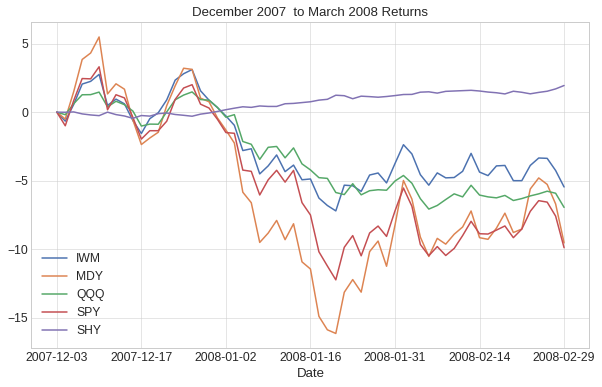

In [6]:
last_quarter:pd.DataFrame = asset_adj_close[:][0:start_date_ix].copy()

for col in last_quarter.columns:
    last_quarter[col] = last_quarter[col] - last_quarter[col][0]

last_quarter.plot(grid=True, title='December 2007  to March 2008 Returns', figsize=(10,6))

<h3>
ETF Selection Algorithm
</h3>

<ol>
<li>
Create a DataFrame that constains the ETF universe and the cash ETF. This will
be referred to as the asset DataFrame
</li>
<li>
<p>
Choose a start date that has three trading months of past data.
</p>
<p>
From start date to the current date, stepping by one trading month
</p>
<ol>
<li>
Choose the highest performing adjusted close asset from the past three trading months
from the asset DataFrame
</li>
<li>
Calculate the daily return for the asset for one month forward from the start date.
</li>
<li>
Calculate the daily return for one month forward from the start date for the bond asset.
</li>
<li>
Apply the asset return to 60% of the current portfolio forward for one trading month
</li>
<li>
Apply the bond return to 40% of the current portfolio forward for one trading month
</li>
<li>
Add the two portfolio components to produce the total portfolio value for the month
</li>
<li>
Concatenate the current portfolio total to the portfolio total series that
will be used to plot the portfolio performance.
</li>
</ol>
<li>
Move the start date forward by one month of trading days
</li>
</li>
</ol>
<p>
The result will be the portfolio total as a Series (with a date index).
</p>

In [7]:
def simple_return(time_series: np.array, period: int) -> List :
    return list(((time_series[i]/time_series[i-period]) - 1.0 for i in range(period, len(time_series), period)))


def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    r_df: pd.DataFrame = pd.DataFrame()
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df


def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros( return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = return_df.values
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i-1] + port_a[i-1] * return_a[i-1]
    return port_a


def portfolio_return(holdings: float,
                     asset_percent: float,
                     bond_percent: float,
                     asset_etfs: pd.DataFrame,
                     bond_etfs: pd.DataFrame,
                     start_date_i: datetime,
                     end_date: datetime) -> pd.DataFrame:
    asset_holding= holdings * asset_percent
    bond_holding=holdings * bond_percent
    back_delta = relativedelta(months=3)
    forward_delta = relativedelta(months=1)
    date_index = asset_etfs.index
    start_date_i = start_date_i
    portfolio_a = np.zeros(0)
    last_index = 0
    while start_date_i <= end_date:
        # Start of the back-test data
        back_start = start_date_i - back_delta
        # End of the back test data
        back_end = start_date_i
        # end of the forward data period (e.g., one month)
        forward_end = start_date_i + forward_delta
        start_ix = findDateIndex(date_index, back_start)
        end_ix = findDateIndex(date_index, back_end)
        forward_ix = findDateIndex(date_index, forward_end)
        if start_ix >= 0 and end_ix >= 0 and forward_ix >= 0:
            # Choose an asset based on the past three months
            asset_df = chooseAsset(start=start_ix, end=end_ix, asset_set=asset_etfs)
            asset_month_df = asset_df[:][end_ix:forward_ix]
            asset_return_df = return_df(asset_month_df)
            bond_df = chooseAsset(start=start_ix, end=end_ix, asset_set=bond_etfs)
            bond_month_df = bond_df[:][end_ix:forward_ix]
            bond_return_df = return_df(bond_month_df)
            port_asset_a = apply_return(asset_holding, asset_return_df)
            port_bond_a = apply_return(bond_holding, bond_return_df)
            port_total_a = port_asset_a + port_bond_a
            portfolio_a = np.append(portfolio_a, port_total_a)
            asset_holding = port_total_a[-1] * asset_percent
            bond_holding = port_total_a[-1] * bond_percent
            last_index = forward_ix
            start_date_i = forward_end
        else:
            break
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    index_start = findDateIndex(date_index, start_date)
    date_index = asset_etfs.index
    portfolio_index = date_index[index_start:last_index]
    portfolio_df.index = portfolio_index
    return portfolio_df


holdings = 100000
equity_percent = 0.6
bond_percent = 0.4

tlt = pd.DataFrame(fixed_income_adjclose['TLT'])
portfolio_df: pd.DataFrame = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=tlt,
                                              start_date_i=start_date,
                                              end_date=end_date)

date_index = equity_adj_close.index
index_start = findDateIndex(date_index, start_date)
end_date = date_index[-1]
if type(end_date) == str:
    end_date = datetime.fromisoformat(end_date)
index_end = findDateIndex(date_index, end_date)
spy_df = equity_adj_close['SPY'][index_start:index_end]
plot_df = portfolio_df.copy()
date_index = equity_adj_close.index
index_start = findDateIndex(date_index, start_date)
end_date = portfolio_df.index[-1]
if type(end_date) == str:
    end_date = datetime.fromisoformat(end_date)
index_end = findDateIndex(date_index, end_date)
spy_df = equity_adj_close['SPY'][index_start:index_end+1]
spy_df.columns = ['SPY']
spy_return = return_df(spy_df)
portfolio_return = return_df(portfolio_df)
spy_return_a = apply_return(start_val=holdings, return_df=spy_return)
spy_port = pd.DataFrame(spy_return_a)
spy_port.columns = ['SPY']
spy_port.index = spy_df.index
plot_df = portfolio_df.copy()
plot_df['SPY'] = spy_port

<h3>
Portfolio Results
</h3>

<p>
The plot below shows the results of a portfolio composed of 60% equity and 40% bonds,
where the equity portion is composed of an equity or "cash" ETF.  The bond portion, in this case,
is always TLT.
</p>

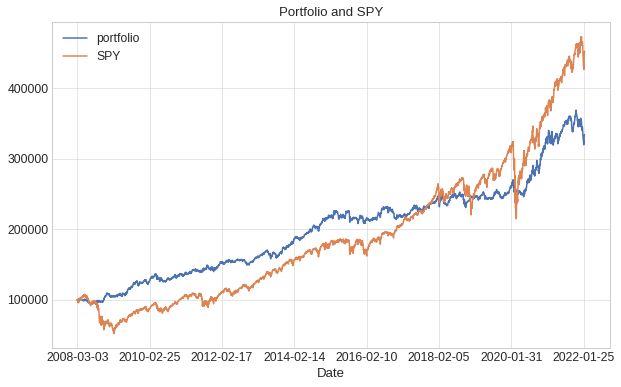

In [8]:
plot_df.plot(grid=True, title='Portfolio and SPY', figsize=(10,6))

trading_days = 253

spy_volatility = round(spy_return.values.std() * sqrt(trading_days) * 100, 2)
port_volatility = round(portfolio_return.values.std() * sqrt(trading_days) * 100, 2)

vol_df = pd.DataFrame([port_volatility, spy_volatility])
vol_df.columns = ['Volatility Percent']
vol_df.index = ['Portfolio', 'SPY']

The volatility (risk) of the ETF selection portfolio is significantly less than the
SPY ETF which tracks the S&P 500.

In [9]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

╒═══════════╤══════════════════════╕
│           │   Volatility Percent │
╞═══════════╪══════════════════════╡
│ Portfolio │                10.06 │
├───────────┼──────────────────────┤
│ SPY       │                20.5  │
╘═══════════╧══════════════════════╛


<h3>
Portfolio Return
</h3>

Average return: Return    9.849231
dtype: float64


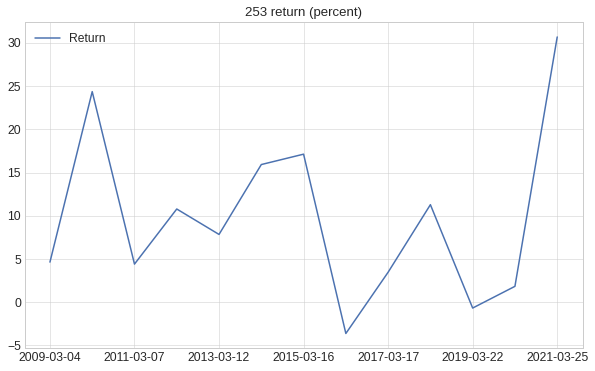

In [10]:
def period_return(portfolio_df: pd.DataFrame, period: int) -> pd.DataFrame:
    date_index = portfolio_df.index
    values_a = portfolio_df.values
    date_list = list()
    return_list = list()
    for i in range(period, len(values_a), period):
        r = (values_a[i]/values_a[i-period]) - 1
        d = date_index[i]
        return_list.append(r)
        date_list.append(d)
    return_df = pd.DataFrame(return_list)
    return_df.index = date_list
    return return_df

period_return_df = period_return(portfolio_df=portfolio_df, period=trading_days)
period_return_df.columns = ['Return']
period_return_df = round(period_return_df * 100, 2)

period_return_df.plot(grid=True, title=f'{trading_days} return (percent)', figsize=(10,6))

print(f'Average return: {period_return_df.mean()}')